# Source link and citation

# Directory Structure

.

├── GSM8607939_UTD-IgG_sample_feature_bc_matrix

│  ├── barcodes.tsv.gz

│  ├── features.tsv.gz

│  └── matrix.mtx.gz

├── GSM8607940_UTD-PD1_sample_feature_bc_matrix

│  ├── barcodes.tsv.gz

│  ├── features.tsv.gz

│  └── matrix.mtx.gz

├── GSM8607941_FRB-IgG_sample_feature_bc_matrix

│  ├── barcodes.tsv.gz

│  ├── features.tsv.gz

│  └── matrix.mtx.gz

├── GSM8607942_FRB-PD1_sample_feature_bc_matrix

│  ├── barcodes.tsv.gz

│  ├── features.tsv.gz

│  └── matrix.mtx.gz

├── GSM8607943_R_sample_feature_bc_matrix

│  ├── barcodes.tsv.gz

│  ├── features.tsv.gz

│  └── matrix.mtx.gz

├── GSM8607944_NR_sample_feature_bc_matrix

│  ├── barcodes.tsv.gz

│  ├── features.tsv.gz

│  └── matrix.mtx.gz

├── GSM8607945_FRBplusPD1-last_sample_feature_bc_matrix

│  ├── barcodes.tsv.gz

│  ├── features.tsv.gz

│  └── matrix.mtx.gz

├── GSM8607946_FRBplusPD1-Vax_sample_feature_bc_matrix

│  ├── barcodes.tsv.gz

│  ├── features.tsv.gz

│  └── matrix.mtx.gz

├── Project2Archive

│  ├── Volcanoplot.R

│  ├── project2.ipynb

│  ├── project2cleanedup.ipynb

│  └── tumor_annotations.csv

├── cell_metadata.csv

└── project2.ipynb

In [1]:
# Import libraries
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib.lines import Line2D
import scrublet

/projectnb/bf528/students/dennig2/.conda/envs/scanpy_scrnaseq/lib/python3.13/site-packages/scanpy/_utils/__init__.py:35: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  from anndata import __version__ as anndata_version
/projectnb/bf528/students/dennig2/.conda/envs/scanpy_scrnaseq/lib/python3.13/site-packages/scanpy/__init__.py:24: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):
/projectnb/bf528/students/dennig2/.conda/envs/scanpy_scrnaseq/lib/python3.13/site-packages/scanpy/readwrite.py:15: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):


# Config

In [2]:
# Set parameters according to those used in the methods, 
# under the section titled "scRNA-seq raw data processing, quality control for cell inclusion in murine studies"
N_TOP_GENES = 3000
N_PCS = 41
LEIDEN_RES = 0.08
MIN_GENES_PER_CELL = 300
MIN_CELLS_PER_GENE = 3
MAX_TOTAL_COUNTS = 80000
MAX_MT_PCT = 10.0
DOUBLETSCRUB_THRESHOLD = 0.2

# Data load

In [3]:
# Expression count matrices were downloaded from GEO accession GSE280954.
# GSE280954_RAW.tar was extracted, with each sample's counts in a separate folder.
# Metadata labels were taken from Seurat object in R, and then exported to csv
def load_all_10x(folders):
    # Create a folder to concatenate all matrix files
    adatas = []
    # Loop through the list of folders and append to the adata list
    for folder in folders:
        # load the matrix
        ad = sc.read_10x_mtx(folder, var_names="gene_symbols")
        # Add the folder name to the loaded adata matrix
        ad.obs["sample"] = folder
        # Append to the larger list
        adatas.append(ad)
    # Concatenate all adata matrices, with 'sample' as batch key
    adata = adatas[0].concatenate(adatas[1:], batch_key="sample", batch_categories=folders)
    return adata
# Initialize a list of all folder names, each a directory from the GEO tarball
folders = [
    "GSM8607939_UTD-IgG_sample_feature_bc_matrix",
    "GSM8607940_UTD-PD1_sample_feature_bc_matrix",
    "GSM8607941_FRB-IgG_sample_feature_bc_matrix",
    "GSM8607942_FRB-PD1_sample_feature_bc_matrix",
    "GSM8607943_R_sample_feature_bc_matrix",
    "GSM8607944_NR_sample_feature_bc_matrix",
    "GSM8607945_FRBplusPD1-last_sample_feature_bc_matrix",
    "GSM8607946_FRBplusPD1-Vax_sample_feature_bc_matrix"
]
# Call the function to create a concatenated adata object
adata = load_all_10x(folders)

/scratch/387783.1.ood/ipykernel_2233013/2628091091.py:16: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata = adatas[0].concatenate(adatas[1:], batch_key="sample", batch_categories=folders)


In [4]:
# Create a function to prepare the adata table to be joined with the metadata labels
def convert_obs_index_from_scanpy_to_metadata(obs_index):
    """
    Converts Scanpy's AnnData index e.g.
    'AAACCTGAGCCACTAT-1-GSM8607939_UTD-IgG_sample_feature_bc_matrix'
    to metadata index e.g.
    'UTD-IgG_AAACCTGAGCCACTAT-1'
    """
    # Split on -GSM
    parts = obs_index.split('-GSM')
    # This is the first chunk of the string before -GSM, for example AAACCTGAGCCACTAT-1
    barcode = parts[0]
    # This is the second chunk of the string after -GSM, for example 8607939_UTD-IgG_sample_feature_bc_matrix
    rest = parts[1]
    # Now split the second chunk on _
    rest_parts = rest.split('_')
    # This is the second chunk in this current split, for example UTD-IgG
    condition = rest_parts[1]
    # Return concatended condition + barcode, for example 'UTD-IgG_AAACCTGAGCCACTAT-1'
    return condition + "_" + barcode
# Create a list to keep track of the new index    
new_index = []
# Loop through each index in the original adata object
for old_idx in adata.obs.index:
    # Convert the index to condition_barcode to match the cell_metadata.csv format
    converted_idx = convert_obs_index_from_scanpy_to_metadata(old_idx)
    # Append the converted object to the new index list
    new_index.append(converted_idx)

# Update the AnnData object index
adata.obs.index = new_index

# R code for getting cell type annotations from Seurat object

# Appending metadata labels to adata object

In [5]:
# Now, read in the cell metadata csv
# Cell metadata csv has columns organized as sample, cell_type, cell where cell is in condition_barcode format
metadata = pd.read_csv("cell_metadata.csv", index_col="cell")
# Drop the sample column to avoid any join errors/duplicate column errors
if 'sample' in adata.obs:
    adata.obs = adata.obs.drop(columns='sample')
# Join the metadata table to the AnnData  object. Now we have annotated cell types from the Seurat object!
adata.obs = adata.obs.join(metadata)

# QC/doublets

In [6]:
# From initial QC through PCA, we follow the Scanpy clustering tutorial:
# https://scanpy.readthedocs.io/en/latest/tutorials/basics/clustering.html

# Function for cell and gene filtering and basic QC
def filter_and_qc(adata):
    # Filter cells to keep only those with at least MIN_GENES_PER_CELL genes detected
    sc.pp.filter_cells(adata, min_genes=MIN_GENES_PER_CELL)
    # Filter genes to keep only those detected in at least MIN_CELLS_PER_GENE cells
    sc.pp.filter_genes(adata, min_cells=MIN_CELLS_PER_GENE)
    # Mark mitochondrial genes by naming convention
    adata.var['mt'] = adata.var_names.str.startswith("mt-")
    # Compute QC metrics: including percentages of counts from mitochondrial genes
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], inplace=True)
    # Filter out cells with high total counts 
    adata = adata[adata.obs['total_counts'] < MAX_TOTAL_COUNTS, :]
    # Filter out cells with high percent of counts from mitochondrial genes 
    adata = adata[adata.obs['pct_counts_mt'] < MAX_MT_PCT, :]
    # Run Scrublet for doublet detection
    scrub = scrublet.Scrublet(adata.X)
    doublet_scores, predicted_doublets = scrub.scrub_doublets()
    # Add Scrublet results to AnnData
    adata.obs['doublet_score'] = doublet_scores
    adata.obs['predicted_doublet'] = predicted_doublets
    # Filter out predicted doublets above threshold
    adata = adata[adata.obs['doublet_score'] < DOUBLETSCRUB_THRESHOLD, :].copy()
    return adata

# Apply the QC and filtering function to the AnnData object
adata = filter_and_qc(adata)

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.34
Detected doublet rate = 2.3%
Estimated detectable doublet fraction = 32.5%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 7.1%
Elapsed time: 134.0 seconds


/scratch/387783.1.ood/ipykernel_2233013/4145116491.py:22: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_score'] = doublet_scores


# Normalization/HVGs/scaling

In [7]:
# Still following this tutorial: https://scanpy.readthedocs.io/en/latest/tutorials/basics/clustering.html
def normalize_and_select_hvgs(adata):
    # Normalize counts per cell so every cell has the same total
    sc.pp.normalize_total(adata, target_sum=1e4)
    # Log-transform the normalized counts
    sc.pp.log1p(adata)
    # Identify highly variable genes using the 'seurat_v3' method.
    sc.pp.highly_variable_genes(adata, flavor='seurat_v3', n_top_genes=N_TOP_GENES)
    # Subset the AnnData to only highly variable genes
    adata = adata[:, adata.var['highly_variable']].copy()
    # Z-score scale each gene to mean 0, variance 1 capped at abs(max_value)=10
    sc.pp.scale(adata, max_value=10)
    return adata
# Call the normalization and select HVGs function to AnnData object
adata = normalize_and_select_hvgs(adata)

/projectnb/bf528/students/dennig2/.conda/envs/scanpy_scrnaseq/lib/python3.13/site-packages/scanpy/preprocessing/_highly_variable_genes.py:73: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


# PCA, neighbors, UMAP, Leiden

In [8]:
# Still following this tutorial: # https://scanpy.readthedocs.io/en/latest/tutorials/basics/clustering.html
# Set PCs and Leiden resolution to that in the methods
def run_umap_leiden(adata, n_pcs=N_PCS, resolution=LEIDEN_RES):
    # Apply PCA
    sc.tl.pca(adata, svd_solver='arpack')
    # Compute the graph of nearest neighbors
    # Set parameters to those in the methods, with n_neighbors being 29 like that in the paper
    sc.pp.neighbors(adata, n_neighbors=29, n_pcs=n_pcs)
    # Compute UMAP, find clusters using leiden algorithm at specified resolution
    sc.tl.umap(adata)
    sc.tl.leiden(adata, resolution=resolution)
    return adata
# Apply UMAP and clustering to the AnnData object using standardized parameters
adata = run_umap_leiden(adata)

/projectnb/bf528/students/dennig2/.conda/envs/scanpy_scrnaseq/lib/python3.13/site-packages/scanpy/preprocessing/_pca/__init__.py:245: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  Version(ad.__version__) < Version("0.9")
/projectnb/bf528/students/dennig2/.conda/envs/scanpy_scrnaseq/lib/python3.13/site-packages/scanpy/neighbors/__init__.py:427: FutureWarning: Use obsm (e.g. `k in adata.obsm` or `adata.obsm.keys() | {'u'}`) instead of AnnData.obsm_keys, AnnData.obsm_keys is deprecated and will be removed in the future.
  if "X_diffmap" in adata.obsm_keys():
/projectnb/bf528/students/dennig2/.conda/envs/scanpy_scrnaseq/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/scratch/387783.1.ood/ipykernel_2233013/4073749872.py:11: FutureWarning: In the future, t

# 3B

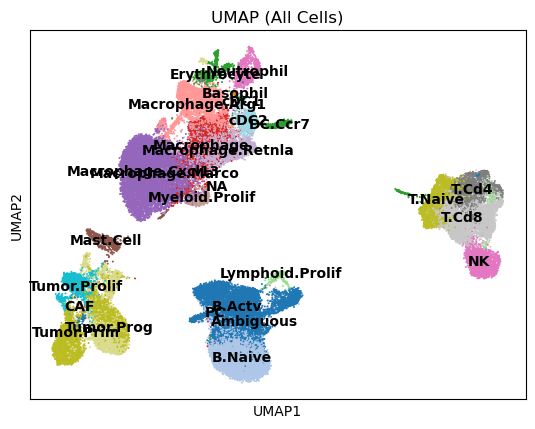

In [9]:
# Plot the UMAP for all cells, coloring points by cell type
def plot_umap(adata, colorby, size=8, title=None):
    sc.pl.umap(adata, color=colorby, palette="tab20", legend_loc="on data", size=size, title=title)

plot_umap(adata, "cell_type", title="UMAP (All Cells)")


# 6A

/projectnb/bf528/students/dennig2/.conda/envs/scanpy_scrnaseq/lib/python3.13/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


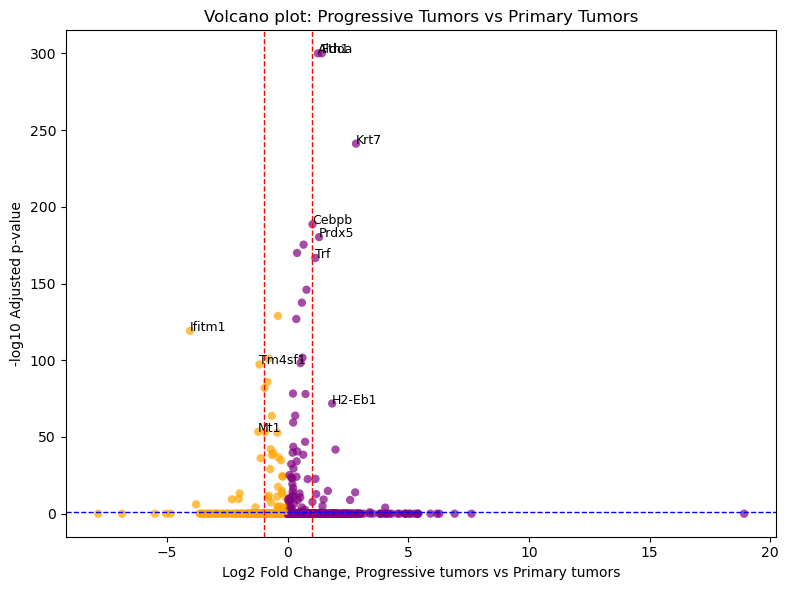

In [ ]:
def volcano_plot_scanpy(adata, groupby="cell_type", group="Tumor.Prog", reference="Tumor.Prim",
                        logfc_thresh=1, padj_thresh=0.05, top_n_labels=10, title=None):
    # Run differential expression analysis between specified groups using the Wilcoxon test
    sc.tl.rank_genes_groups(adata, groupby=groupby, groups=[group], reference=reference, method="wilcoxon")

    # Extract differential expression results for the chosen group from AnnData.uns
    rg = adata.uns["rank_genes_groups"]
    names = rg["names"][group]
    logfc = rg["logfoldchanges"][group]
    padj = rg["pvals_adj"][group]

    # Build results dataframe with gene names, log2 fold changes, and adjusted p-values
    # Also compute -log10(padj) for volcano plot y-axis
    results = pd.DataFrame({
        "gene": names,
        "logfc": logfc,
        "padj": padj,
        "-log10_padj": -np.log10(np.clip(padj, 1e-300, 1))
    })

    # Assign colors: genes upregulated in Tumor.Prog are purple, downregulated are orange
    results["color"] = np.where(results["logfc"] > 0, "purple", "orange")

    # Create volcano plot: log2 fold change vs -log10 adjusted p-value 
    plt.figure(figsize=(8,6))
    plt.scatter(results["logfc"], results["-log10_padj"], c=results["color"], alpha=0.7, edgecolor="none")

    # Add threshold lines for minimum log2 fold change and significance
    # Right logFC cutoff
    plt.axvline(x=logfc_thresh, color="red", ls="--", lw=1)   
    # Left logFC cutoff
    plt.axvline(x=-logfc_thresh, color="red", ls="--", lw=1)  
    # Significance cutoff
    plt.axhline(y=-np.log10(padj_thresh), color="blue", ls="--", lw=1) 

    # Select significant genes: padj < padj_thresh and absolute logFC > logfc_thresh
    sig_genes = results[(results["padj"] < padj_thresh) & (abs(results["logfc"]) > logfc_thresh)]
    # Sort selected genes by padj and log2 fold change, take up to top_n_labels for annotation
    top_genes_to_label = sig_genes.sort_values(["padj", "logfc"]).head(top_n_labels)

    # Annotate genes on the volcano plot at their log2 fold change, -log10 padj coordinates
    for idx, gene_row in top_genes_to_label.iterrows():
        gene_name = gene_row["gene"]
        log_fold_change = gene_row["logfc"]
        minus_log10_padj = gene_row["-log10_padj"]
        plt.text(x=log_fold_change, y=minus_log10_padj, s=gene_name, fontsize=9)

    # Set axis labels and plot title
    plt.xlabel("Log2 Fold Change, Progressive tumors vs Primary tumors")
    plt.ylabel("-log10 Adjusted p-value")
    plt.title(title or f"Volcano plot: {group} vs {reference}")
    plt.tight_layout()
    plt.show()

# Subset AnnData to only primary and progressive tumor cells
tumor_cells = adata[adata.obs["cell_type"].isin(["Tumor.Prim", "Tumor.Prog"]), :].copy()

# Call volcano plot function to compare Tumor.Prog vs Tumor.Prim
volcano_plot_scanpy(
    tumor_cells, groupby="cell_type", group="Tumor.Prog", reference="Tumor.Prim",
    logfc_thresh=1, padj_thresh=0.05, top_n_labels=10, title="Volcano plot: Progressive Tumors vs Primary Tumors"
)

# 6F

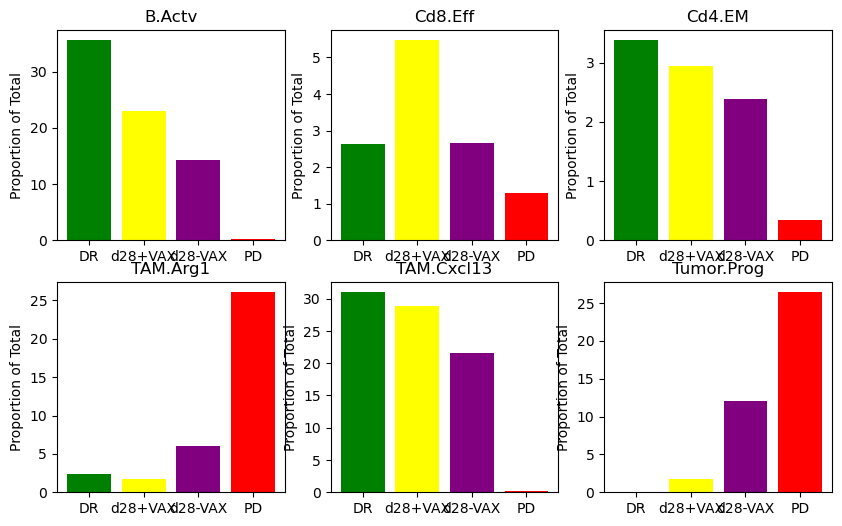

In [ ]:
def plot_celltype_proportions(adata):
    # Define the internal condition names exactly as they appear in adata.obs['sample']
    internal_conditions = ["DR", "FRBplusPD1-Vax", "FRBplusPD1-last", "PD"]

    # Select the six cell types used in the figure, using the names present in adata.obs['cell_type']
    figure_cell_types = ["B.Actv", "T.Cd8", "T.Cd4", 
                         "Macrophage.Arg1", "Macrophage.Cxcl13", "Tumor.Prog"]

    # Initialize a results dataframe with cell types as rows and internal condition labels as columns
    results = pd.DataFrame(index=figure_cell_types, columns=internal_conditions)

    # Compute proportions of each cell type within each condition
    for cond in internal_conditions:
        # Restrict to cells belonging to this condition
        subset = adata.obs[adata.obs["sample"] == cond]

        # Total number of cells in this condition
        total = len(subset)
        # Count occurrences of each cell type in this condition
        counts = subset["cell_type"].value_counts()
        # Compute proportions of each cell type within each condition
        for ct in figure_cell_types:
            prop = (counts.get(ct, 0) / total) * 100
            results.loc[ct, cond] = prop

    # Rename the columns using the labels shown in the published figure
    results = results.rename(columns={
        "DR": "DR",
        "FRBplusPD1-Vax": "d28+VAX",
        "FRBplusPD1-last": "d28-VAX",
        "PD": "PD"
    })

    # Rename row labels to match the paper's cell type names
    results = results.rename(index={
        "Macrophage.Arg1": "TAM.Arg1",
        "Macrophage.Cxcl13": "TAM.Cxcl13",
        "T.Cd8": "Cd8.Eff",
        "T.Cd4": "Cd4.EM"
    })

    # Ordered list of condition names as they should appear in the plot
    conditions = ["DR", "d28+VAX", "d28-VAX", "PD"]

    # Define the color assigned to each condition
    color_map = {
        "DR": "green",
        "d28+VAX": "yellow",
        "d28-VAX": "purple",
        "PD": "red"
    }
    # Convert the color map to a list in plotting order
    colors = [color_map[c] for c in conditions]

    # Create a 2 × 3 panel of barplot, one subplot per cell type
    fig, axes = plt.subplots(2, 3, figsize=(10, 6))
    axes = axes.flatten()

    # Plot the proportion barplot for each cell type
    for i, ct in enumerate(results.index):
        ax = axes[i]
        ax.bar(conditions, results.loc[ct].astype(float), color=colors)
        ax.set_title(ct)
        ax.set_ylabel("Proportion of Total")
    plt.tight_layout()
    plt.show()
    return results, fig, axes

results, fig, axes = plot_celltype_proportions(adata)
